In [42]:
# Linear Regression Model:
from __future__ import print_function
from __future__ import division
from datetime import datetime, timedelta, date
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from  operator import add
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
import numpy as np
import pandas as pd
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# Module Constants
datetime_event = '%m/%d/%y %H:%M'
datetime_event2 = '%m/%d/%y %H:%M:%S'
APP_NAME = 'Sharaf Training Linear Model for Objects Sold'

In [525]:
# Functions for cleaning:
def exclude_zones(extracted_features, min_data):
    # Getting the zones:
    zones_to_keep = extracted_features.map(lambda x: (x[5], 1)).reduceByKey(add).filter(lambda x: x[1] > min_data).map(
        lambda x: x[0]).collect()
    zones_to_keep.remove('TopExitRight #1')
    #zones_to_keep.remove('Exit Front')
    #zones_to_keep.remove('Stock Room 1')
    #zones_to_keep.remove('HVS')
    #zones_to_keep.remove('TV')
    result = extracted_features.filter(lambda x: x[5] in zones_to_keep)
    return result

#zones_to_keep.remove('HVS')
    #zones_to_keep.remove('Stock Room 1')
    #zones_to_keep.remove('Stock Room2')

# FUNCTIONS for Predicting
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

def extract_features(record, cat_len, mappings):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[0:-1]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    return cat_vec
    #num_vec = np.array([float(field) for field in record[0:3]])
    #return np.concatenate((num_vec, cat_vec))
def extract_label(record):
    return float(record[-1])

# Functions in order to get back the features vector:

def get_pos(binary_vec):
    pos=0
    for i in binary_vec:
        if i==1:
            position=pos
        pos=pos+1   
    return position

def get_features(binary_row,mappings):
    feature_back=list()
    binary_len=[len(mappings[i]) for i in range(0,len(mappings))]
    inv_map= [{v: k for k, v in mappings[i].items()} for i in range(0,len(mappings))]
    inv_map= [{v: k for k, v in mappings[i].items()} for i in range(0,len(mappings))]
    for field in range(0,len(mappings)):
        if field==0:
            binary_vec=binary_row[0:binary_len[field]]
        else:
            binary_vec=binary_row[sum(binary_len[:field]):sum(binary_len[:(field+1)])]
        feature_back.append(inv_map[field][get_pos(binary_vec)])     
    return feature_back


In [526]:
# Getting features per month
features_cr_raw_jan = sc.pickleFile('/tmp/ZoneDataJan')
features_cr_raw_feb=sc.pickleFile('/tmp/ZoneDataRevenuFeb')


In [527]:
# Uniting months
features_cr_raw=sc.pickleFile('/tmp/ZoneData3M')

In [528]:
mean_feat=mean(features_cr_raw.map(lambda x: x[-1]).collect())
mean_feat

29447.187271397219

In [529]:
std_feat=std(features_cr_raw.map(lambda x: x[-1]).collect())
std_feat

318970.31202619441

In [534]:
# Loading the features:

features_cr = exclude_zones(
        features_cr_raw.map(lambda x: (x[0],x[1], x[2], x[3], x[4], x[5], float(((x[6]-mean_feat)/std_feat)))),20)#.filter(
#            lambda x: x[4] != None),20).filter(lambda x: x[5] != -inf)

features_cr=features_cr.filter(lambda x: x[-1]<0.25)

# Getting the features ready for training
numberFeatures = len(features_cr.first()) - 1
mappings = [get_mapping(features_cr, i) for i in range(0, numberFeatures)]
print ("feature example : "+str(features_cr.first()))
print ("features total: "+str(features_cr.count()))
# Month:
dictio_month = {}
for i in range(12):
    dictio_month[i + 1] = i
mappings[1] = dictio_month
# Year: ?

feature example : (2016, 3, 2, 9, 2, 'Exit Front', -0.04871358457373047)
features total: 1283


(array([ 875.,   87.,   98.,   71.,   66.,   30.,   19.,   18.,   13.,    6.]),
 array([-0.09231952, -0.05820005, -0.02408057,  0.01003891,  0.04415838,
         0.07827786,  0.11239733,  0.14651681,  0.18063629,  0.21475576,
         0.24887524]),
 <a list of 10 Patch objects>)

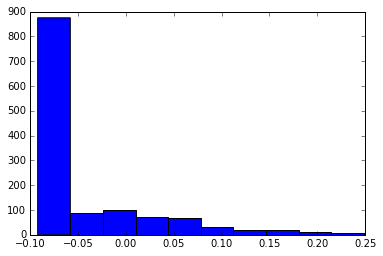

In [535]:
hist(features_cr.map(lambda x:x[-1]).collect())

In [536]:
# Working with the Mapping:
cat_len = sum(map(len, mappings))
data = features_cr.map(lambda r: LabeledPoint(extract_label(r), extract_features(r, cat_len, mappings)))


In [537]:
features_cr.collect()

[(2016, 3, 2, 9, 2, 'Exit Front', -0.04871358457373047),
 (2016, 1, 3, 18, 0, 'Exit Front', 0.11598199372725541),
 (2016, 3, 4, 26, 5, 'IT Accessories', -0.0904133901622446),
 (2016, 2, 3, 18, 3, 'TV', -0.09219725523854448),
 (2016, 3, 3, 17, 3, 'Electronics', -0.06905403556675954),
 (2016, 1, 4, 23, 5, 'IT Accessories', -0.08656036700095719),
 (2016, 3, 3, 19, 5, 'Exit Back', 0.013796935208946275),
 (2016, 1, 4, 23, 5, 'Home Appliances', -0.09160158851710867),
 (2016, 1, 2, 10, 6, 'MAC', -0.09183672011767544),
 (2016, 3, 1, 7, 0, 'Photography', 0.029582103326995193),
 (2016, 2, 4, 28, 6, 'MAC', -0.09231952367083919),
 (2016, 3, 2, 10, 3, 'Telecom', -0.08179503322947072),
 (2016, 1, 3, 18, 0, 'Store Front', -0.08193924727781834),
 (2016, 3, 1, 2, 2, 'Stock Room 1', -0.0918241797656452),
 (2016, 1, 2, 8, 4, 'Store Front', -0.04173174358090129),
 (2016, 3, 4, 28, 0, 'Samsung', -0.09044160595431262),
 (2016, 2, 2, 14, 6, 'Stock Room 1', -0.0737692079301251),
 (2016, 1, 2, 13, 2, 'Samsung'

In [539]:
# Training and Evaluating with all the set
linear_model_total = LinearRegressionWithSGD.train(data, iterations=2500,step=0.01, regParam=i,intercept=True)
valuesPredsError = data.map(lambda p: (p.label, linear_model_total.predict(p.features))).map(
    lambda x: (x[0],x[1]*std_feat+mean_feat)).map(lambda x:(x[0],x[1],abs(1-(x[1]/x[0]))))
print ("total number: "+ str(valuesPredsError.count()))
PE=valuesPredsError.map(lambda x:x[2]).mean()
print ("filtered number: "+str(valuesPredsError.filter(lambda x:x[2]).count()))
print ("Training Error for  : " +str(PE))

total number: 1283
filtered number: 1283
Training Error for  : 36639234.1134


In [544]:
mean(data.map(lambda p: (p.label)).collect())

-0.047334414642050675

In [479]:
error_list=[]
w=list()
for i in range(0,5):
    # Dividing in Training and Test Set:
    train, test = features_cr.randomSplit([7, 3])
    data_train = train.map(lambda r: LabeledPoint(extract_label(r), extract_features(r, cat_len, mappings)))
    data_test = test.map(lambda r: LabeledPoint(extract_label(r), extract_features(r, cat_len, mappings)))


    # Training and Evaluating
    linear_model_train = LinearRegressionWithSGD.train(data_train, iterations=2000,step=0.75, regParam=0.8, intercept=True)
    
    valuesAndPreds_train = data_train.map(lambda p: (p.label, linear_model_train.predict(p.features))).map(
        lambda x: (x[0]),x[1])

    valuesAndPreds_test = data_test.map(lambda p: (p.label, linear_model_train.predict(p.features))).map(
        lambda x: (x[0],x[1]))

    PE = valuesAndPreds_test.map(lambda (v, p): np.abs(1 - (v / p))).reduce(lambda x, y: x + y) / valuesAndPreds_test.count()

    error_list.append(PE)
    w.append(linear_model_train.weights)

In [480]:
error_list

[10.556532453393762,
 9.4941610618487982,
 2.4246053142547175,
 3.7511841807896853,
 2.6358906680967551]

(array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  2.42460531,   3.23779803,   4.05099074,   4.86418346,
          5.67737617,   6.49056888,   7.3037616 ,   8.11695431,
          8.93014703,   9.74333974,  10.55653245]),
 <a list of 10 Patch objects>)

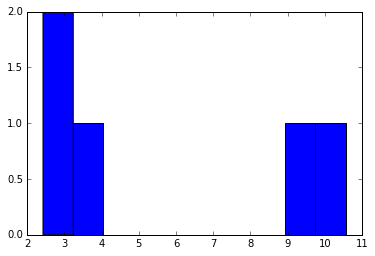

In [481]:
# Histogram of the errors
hist(error_list)

In [496]:
valuesPredsError = data_train.map(lambda p: (p.label, linear_model_total.predict(p.features)))

In [483]:
VPE=valuesPredsError.map(lambda x:(x[0],x[1],abs(1-(x[1]/x[0]))))

In [484]:
VPE=VPE.filter(lambda x:x[2]<2)

In [485]:
VPE.count()

1174

In [486]:
VPE.map(lambda x: x[2]).mean()

0.4086946696404376

In [497]:
# Plotting the true vs Prediction
x=valuesPredsError.map(lambda x:x[0]).collect()
y=valuesPredsError.map(lambda x:x[1]).collect()

In [547]:
res=[(x[i]-y[i]) for i in range(0,len(x))]

(array([ 767.,  470.,    9.,    6.,    1.,    0.,    2.,    0.,    1.,    2.]),
 array([ -1.62385298e-01,   1.04847575e-04,   1.62594993e-01,
          3.25085139e-01,   4.87575285e-01,   6.50065430e-01,
          8.12555576e-01,   9.75045722e-01,   1.13753587e+00,
          1.30002601e+00,   1.46251616e+00]),
 <a list of 10 Patch objects>)

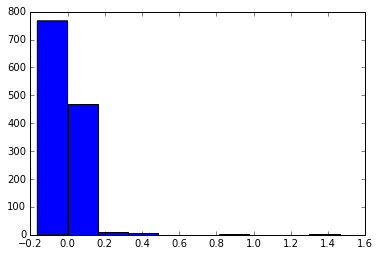

In [549]:
hist(res)

In [499]:
x[280]

-0.08092347876336992

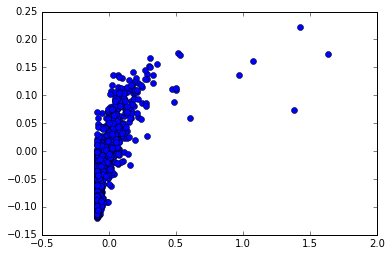

In [500]:
plot(x,y,'o')

In [431]:
# Getting back the features
featsValuesPreds= data_train.map(lambda p: (get_features(p.features,mappings),
                                      np.power(10,p.label), np.power(10,linear_model_total.predict(p.features)))).map(
                                    lambda x: (x[0][0],x[0][1],x[0][2],x[0][3],x[0][4],x[0][5],x[1],x[2]))
featsValuesPreds.first()
# DataFRames:
df=pd.DataFrame(featsValuesPreds.collect(),columns=['year','month','WM','DM','DW','zones','true','predicted'])
df.head(20)

,year,month,WM,DM,DW,zones,true,predicted
0,2016,3,2,9,2,Exit Front,13909.0,23879.338796
1,2016,1,3,18,0,Exit Front,66442.0,39204.532938
2,2016,3,4,26,5,IT Accessories,608.0,915.980386
3,2016,2,3,18,3,TV,39.0,605.814517
4,2016,3,3,17,3,Electronics,7421.0,4322.647943
5,2016,1,4,23,5,IT Accessories,1837.0,1112.695833
6,2016,3,3,19,5,Exit Back,33848.0,16322.630169
7,2016,1,4,23,5,Home Appliances,229.0,1613.814811
8,2016,1,2,10,6,MAC,154.0,903.008283
9,2016,3,1,7,0,Photography,38883.0,32847.732993


## Analytics

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Functions for analytics:
def error_avg(x,y):
    z=list()
    z.append(abs(x[0])+abs(y[0]))
    z.append(x[1]+y[1])
    return z

In [436]:
# Dicionary Zone - Error
zoneValPreds=featsValuesPreds.map(lambda x:(str(x[1])+' - '+str(x[3]),((1-(x[6]/x[7])),1))).reduceByKey(error_avg).map(lambda x: (x[0],round((x[1][0]/x[1][1])*100)))
dictio_zone_error=zoneValPreds.collectAsMap()
dictio_zone_error

{'1 - 1': 51.0,
 '1 - 10': 51.0,
 '1 - 11': 74.0,
 '1 - 12': 59.0,
 '1 - 13': 83.0,
 '1 - 14': 140.0,
 '1 - 15': 69.0,
 '1 - 16': 104.0,
 '1 - 17': 40.0,
 '1 - 18': 83.0,
 '1 - 19': 52.0,
 '1 - 2': 75.0,
 '1 - 20': 248.0,
 '1 - 21': 74.0,
 '1 - 22': 833.0,
 '1 - 23': 115.0,
 '1 - 24': 36.0,
 '1 - 25': 51.0,
 '1 - 26': 387.0,
 '1 - 27': 134.0,
 '1 - 28': 66.0,
 '1 - 29': 64.0,
 '1 - 3': 81.0,
 '1 - 30': 98.0,
 '1 - 31': 61.0,
 '1 - 4': 91.0,
 '1 - 5': 148.0,
 '1 - 6': 73.0,
 '1 - 7': 260.0,
 '1 - 8': 70.0,
 '1 - 9': 121.0,
 '2 - 1': 292.0,
 '2 - 10': 167.0,
 '2 - 11': 104.0,
 '2 - 12': 116.0,
 '2 - 13': 135.0,
 '2 - 14': 190.0,
 '2 - 15': 111.0,
 '2 - 16': 61.0,
 '2 - 17': 98.0,
 '2 - 18': 131.0,
 '2 - 19': 61.0,
 '2 - 2': 76.0,
 '2 - 20': 162.0,
 '2 - 21': 179.0,
 '2 - 22': 116.0,
 '2 - 23': 224.0,
 '2 - 24': 149.0,
 '2 - 25': 260.0,
 '2 - 26': 85.0,
 '2 - 27': 83.0,
 '2 - 28': 126.0,
 '2 - 29': 68.0,
 '2 - 3': 78.0,
 '2 - 4': 47.0,
 '2 - 5': 84.0,
 '2 - 6': 55.0,
 '2 - 7': 39.0,
 '2 -

In [383]:
df['per_error'] = df.apply (lambda row: abs(1-row['true']/row['predicted']),axis=1)

In [384]:
df.groupby(['zones']).mean()['per_error']

zones
Electronics          1.105407
Exit Back            0.698669
Exit Front           0.732468
Gaming               1.396010
HVS                  3.353068
Home Appliances      1.248722
IT                   0.687181
IT Accessories       2.337879
MAC                  1.673229
Personal Care        0.915166
Photography          0.694212
Samsung              1.280835
Stock Room 1         3.217689
Store Back           0.805470
Store Front          0.931793
TV                   1.635336
Telecom              0.945386
Theater              1.155040
TopExitRight #1    372.057225
Name: per_error, dtype: float64

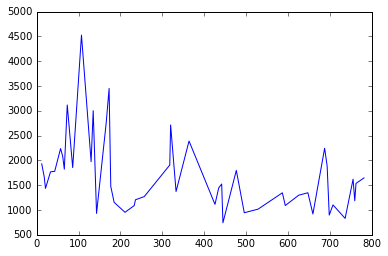

In [359]:
plot(df[df['zones']=='IT Accessories'].predicted)